In [1]:
import yaml
from os import makedirs
from os.path import exists
from glob import glob

import numpy as np
from ase.build import make_supercell
from ase.io import read, write
from ase.spacegroup.symmetrize import FixSymmetry
from ase.units import _amu as amu, kB, _e as eV, _hbar as hbar
from calorine.calculators import CPUNEP
from calorine.gpumd import read_runfile, read_thermo
from calorine.tools import analyze_data, relax_structure
from matplotlib import pyplot as plt, colormaps
from pandas import DataFrame, read_csv, read_json
from spglib import get_spacegroup
import mplpub
mplpub.setup(template='acs')

In [3]:
xc = 'HSE'
model_filename = f'models/nep-hse06.txt'

data = []
for fname in glob('structures/POSCAR*'):
    structure_name = fname.split('/')[-1].replace('.xyz', '')
    outfile = f'structures/{structure_name}'
    try:
        structure = read(outfile)
    except:
        structure = read(fname)
    structure.calc = CPUNEP(model_filename)
    structure.set_constraint(FixSymmetry(structure))
    relax_structure(structure)
    
    write(outfile, structure)

    structure_tuple = (
        structure.get_cell(),
        structure.get_scaled_positions(),
        structure.numbers,
    )
    spg = get_spacegroup(structure_tuple)

    data.append(dict(
        structure_name=structure_name,
        energy=structure.get_potential_energy() / len(structure),
        natoms=len(structure),
        filename=fname,
        spacegroup=spg,
    ))
df_rlx = DataFrame(data).sort_values('energy', ignore_index=True)
df_rlx['energy_difference'] = np.round(1e3 * (df_rlx.energy - df_rlx.energy.min()), decimals=1)

reference_energy = df_rlx[df_rlx.structure_name == 'BaZrS3-spg62-Pnma'].energy.min()
df_rlx

,structure_name,energy,natoms,filename,spacegroup,energy_difference
0,POSCAR-62,-2.047060,20,structures/POSCAR-62,Pnma (62),0.0
1,POSCAR-140,-2.041052,10,structures/POSCAR-140,I4/mcm (140),6.0


In [4]:
structures = {}
structures['a+b-b-'] = 'structures/POSCAR-140'
structures['a0a0c-'] = 'structures/POSCAR-62'

invert_glazer = {}
invert_glazer['BaZrS3-spg62-Pnma'] = 'a+b-b-'
invert_glazer['BaZrS3-spg140-I4mcm'] = 'a0a0c-'

repeat = {}
repeat['a+b-b-'] = 2 * np.array([[6, 0, 0], [0, 6, 0], [0, 0, 4]])
repeat['a0a0c-'] = 2 * np.array([[0, 6, 6], [6, 0, 6], [4, 4, 0]])

labels = {}
labels['a+b-b-'] = '$a^+b^-b^-$'
labels['a0a0c-'] = '$a^0a^0c^-$'

colors = {}
colors['a+b-b-'] = 'C0'
colors['a0a0c-'] = 'C1'  
structures

{'a+b-b-': 'structures/POSCAR-140', 'a0a0c-': 'structures/POSCAR-62'}

In [5]:
n_equil = 50000
model_filename = 'nep.txt'
time_step = 2.0
dump_thermo = 200
dump_position = int(n_equil / 20)

for glazer, fname in structures.items():
    structure = read(fname)
    supercell = make_supercell(structure, repeat[glazer])
    cell = supercell.cell[:] 
    cell[np.abs(cell) < 1e-5] = 0
    supercell.set_cell(cell, scale_atoms=True)

    for temperature in np.arange(50, 751, 50):

        # set up directory
        dname = f'prep/equilibration-{glazer}-nat{len(supercell)}-T{temperature}-ns{n_equil}'
        if exists(dname.replace('prep', f'runs-{xc}')):
            continue
        makedirs(dname, exist_ok=True)
        
        # write model.xyz
        write(f'{dname}/model.xyz', supercell)
        
        # write run.in
        with open(f'{dname}/run.in', 'w') as f:
            f.write(f'potential     ../{model_filename}\n')
            f.write(f'velocity      {2 * temperature}\n')
            f.write(f'ensemble      npt_scr {temperature} {temperature} 100'
                    f'   0 0 0   80 80 80  200\n')
            f.write(f'time_step     {time_step}\n')
            f.write(f'dump_thermo   {dump_thermo}\n')
            f.write(f'dump_position {dump_position}\n')
            f.write(f'run           {n_equil}\n')

In [6]:
def get_thermodynamic_data(
    dname: str,
):
    """Compile thermodynamic data from a run in the form of a DataFrame.

    Parameters
    ----------
    dname
        directory name
    """

    params = read_runfile(f'{dname}/run.in')
    for p, v in params:
        if p == 'time_step':
            time_step = v
        elif p == 'dump_thermo':
            dump_thermo = v
        elif p == 'dump_position':
            dump_position = v

    conf = read(f'{dname}/model.xyz')
    natoms = len(conf)

    try:
        df = read_thermo(f'{dname}/thermo.out')
    except FileNotFoundError:
        df = None
    else:
        df['time'] = df.index * dump_thermo * time_step * 1e-3   # in ps
        df['potential_energy'] /= natoms
        df['pressure'] = (df.stress_xx + df.stress_yy + df.stress_zz) / 3
        if 'cell_xy' in df:
            df['alat'] = np.sqrt(df.cell_xx ** 2 + df.cell_xy ** 2 + df.cell_xz ** 2)
            df['blat'] = np.sqrt(df.cell_yx ** 2 + df.cell_yy ** 2 + df.cell_yz ** 2)
            df['clat'] = np.sqrt(df.cell_zx ** 2 + df.cell_zy ** 2 + df.cell_zz ** 2)
            volume = (df.cell_xx * df.cell_yy * df.cell_zz +
                      df.cell_xy * df.cell_yz * df.cell_xz +
                      df.cell_xz * df.cell_yx * df.cell_zy -
                      df.cell_xx * df.cell_yz * df.cell_zy -
                      df.cell_xy * df.cell_yx * df.cell_zz -
                      df.cell_xz * df.cell_yy * df.cell_zx) / natoms 
        else:
            df['alat'] = df.cell_xx
            df['blat'] = df.cell_yy
            df['clat'] = df.cell_zz
            volume = (df.cell_xx * df.cell_yy * df.cell_zz) / natoms
        df['volume'] = volume

    return df

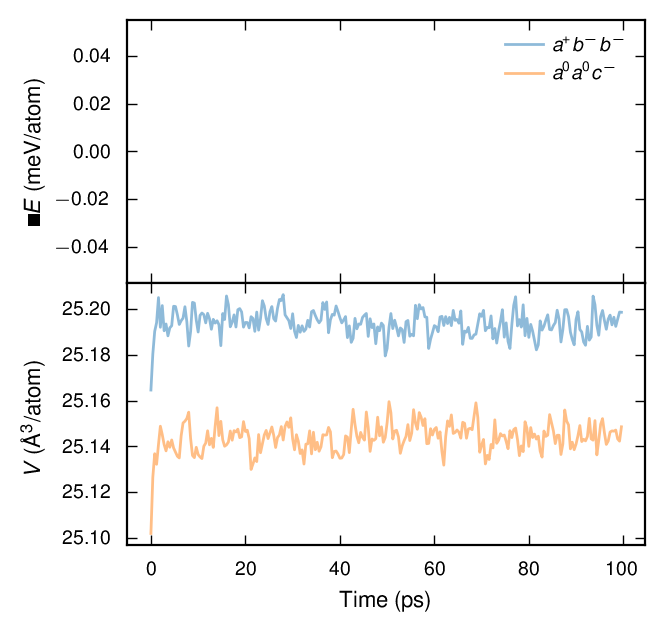

In [15]:
xc = 'HSE'

fig, axes = plt.subplots(
    figsize=(3.4, 3.2),
    dpi=200,
    nrows=2,
    sharex=True,
)

temperature = 100
n_equil = 50000

for glazer in structures:
    dname = f'runs-{xc}/equilibration-{glazer}-nat23040-T{temperature}-ns{n_equil}'
    df = get_thermodynamic_data(dname)
    if df is None:
        continue
    kwargs = dict(
        alpha=0.5,
        label=labels[glazer],
        color=colors[glazer],
    )
    axes[0].plot(df.time, 1e3 * (df.potential_energy - reference_energy), **kwargs)
    axes[1].plot(df.time, df.volume, **kwargs)

axes[-1].set_xlabel('Time (ps)')
axes[0].set_ylabel('$\Delta E$ (meV/atom)')
axes[1].set_ylabel('$V$ (Å$^3$/atom)')
axes[0].legend(frameon=False)

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.align_ylabels()

In [16]:
data = []
for dname in sorted(glob(f'runs-{xc}/equilibration-*')):
    glazer = dname.split('/')[-1].replace('equilibration-', '').split('-nat')[0]
    temperature = int(dname.split('/')[-1].replace('equilibration-', '').split('-T')[-1].split('-')[0])

    df = get_thermodynamic_data(dname)
    if df is None:
        print(f'Skipping {dname} (1)')
        continue
    df = df[df.index >= 50]
    if len(df) == 0:
        print(f'Skipping {dname} (2)')
        continue

    record = dict(
        glazer=glazer,
        target_temperature=temperature,
        ndata=len(df),
    )
    data.append(record)

    for prop in ['temperature', 'potential_energy', 'volume', 'alat', 'blat', 'clat']:
        res = analyze_data(df[prop])
        for key, value in res.items():
            record[f'{prop}_{key}'] = value

df_averages = DataFrame(data).sort_values(['glazer', 'target_temperature'], ignore_index=True)

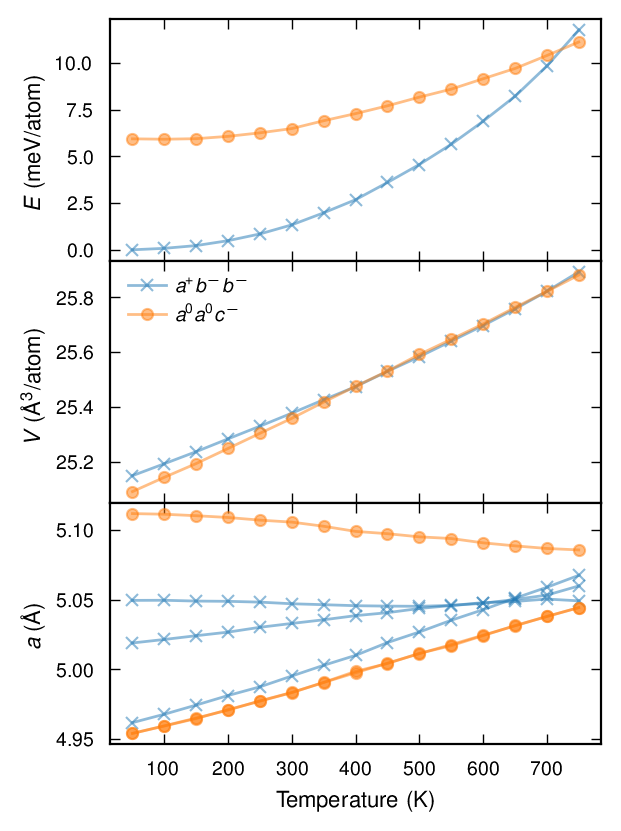

In [17]:
fig, axes = plt.subplots(
    figsize=(3.2, 4.2),
    dpi=200,
    nrows=3,
    sharex=True,
)

reference_energy = np.min(df_averages.potential_energy_mean - 1.5 * kB * df_averages.temperature_mean)
for glazer, df in df_averages.groupby('glazer'):
    kwargs = dict(
        marker='o' if glazer == 'a0a0c-' else 'x',
        markersize=4,
        alpha=0.5,
        color=colors[glazer],
        label=labels[glazer],
    )
    
    axes[0].plot(df.temperature_mean,
                 1e3 * (df.potential_energy_mean - 1.5 * kB * df.temperature_mean - reference_energy),
                 **kwargs)
    axes[1].plot(df.temperature_mean, df.volume_mean, **kwargs)
    axes[2].plot(df.temperature_mean, df.alat_mean / 12 / np.sqrt(2), **kwargs)
    axes[2].plot(df.temperature_mean, df.blat_mean / 12 / np.sqrt(2), **kwargs)
    axes[2].plot(df.temperature_mean, df.clat_mean / 16, **kwargs)

axes[0].set_ylabel('$E$ (meV/atom)')
axes[1].set_ylabel('$V$ (Å$^3$/atom)')
axes[2].set_ylabel('$a$ (Å)')
axes[-1].set_xlabel('Temperature (K)')
axes[1].legend(frameon=False)

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.align_ylabels()

In [18]:
average_structures = {}

for dname in sorted(glob(f'runs-{xc}/equilibration-*')):
    glazer = dname.split('/')[-1].replace('equilibration-', '').split('-nat')[0]
    temperature = int(dname.split('/')[-1].replace('equilibration-', '').split('-T')[-1].split('-')[0])

    try:
        frames = read(f'{dname}/movie.xyz', '5:')
    except FileNotFoundError:
        #print(f'Skipping {glazer} {temperature}')
        continue
    print(f'Parsing {glazer} {temperature} {len(frames)}')

    cell_avg = np.zeros((3, 3))
    positions_avg = np.zeros((len(frames[0]), 3))
    xred_prev = None
    for frame in frames:
        cell_avg += frame.get_cell()
        xred = frame.get_scaled_positions()
        if xred_prev is not None:
            dx = xred - xred_prev
            xred -= np.rint(dx)
        positions_avg += xred @ frame.get_cell()
        xred_prev = xred

    cell_avg /= len(frames)
    positions_avg /= len(frames)
    frame.set_cell(cell_avg)
    frame.set_positions(positions_avg)
    average_structures[(glazer, temperature)] = frame.copy()

Parsing a+b-b- 100 15
Parsing a+b-b- 150 15
Parsing a+b-b- 200 15
Parsing a+b-b- 250 15
Parsing a+b-b- 300 15
Parsing a+b-b- 350 15
Parsing a+b-b- 400 15
Parsing a+b-b- 450 15
Parsing a+b-b- 50 15
Parsing a+b-b- 500 15
Parsing a+b-b- 550 15
Parsing a+b-b- 600 15
Parsing a+b-b- 650 15
Parsing a+b-b- 700 15
Parsing a+b-b- 750 15
Parsing a0a0c- 100 15
Parsing a0a0c- 150 15
Parsing a0a0c- 200 15
Parsing a0a0c- 250 15
Parsing a0a0c- 300 15
Parsing a0a0c- 350 15
Parsing a0a0c- 400 15
Parsing a0a0c- 450 15
Parsing a0a0c- 50 15
Parsing a0a0c- 500 15
Parsing a0a0c- 550 15
Parsing a0a0c- 600 15
Parsing a0a0c- 650 15
Parsing a0a0c- 700 15
Parsing a0a0c- 750 15


In [11]:
spring = 4.0
springs = ' '.join([f'{s} {spring}' for s in set(structure.symbols)])

n_eq, n_sample = 5000, 20000
n_total = 2 * (n_eq + n_sample)

for (glazer, temperature), supercell in average_structures.items():

    for run in [1]:

        # set up directory
        dname = f'prep/einstein_integration-{glazer}-nat{len(supercell)}-T{temperature}-ns{n_total}-spring{spring}-run{run}'
        if exists(dname.replace('prep', f'runs-{xc}')):
            continue
        makedirs(dname, exist_ok=True)
        
        # write model.xyz
        write(f'{dname}/model.xyz', supercell)
        
        # write run.in
        with open(f'{dname}/run.in', 'w') as f:
            # equilibration
            f.write(f'potential     ../{model_filename}\n')
            f.write(f'velocity      {2 * temperature}\n')
            f.write(f'ensemble      nvt_lan {temperature} {temperature} 100\n')
            f.write(f'time_step     {time_step}\n')
            f.write(f'run           10000\n')
    
            # production
            f.write(f'ensemble      ti_spring temp {temperature} tperiod 100'
                    f' tequil {n_eq} tswitch {n_sample} spring {springs}\n')
            f.write(f'time_step     {time_step}\n')
            f.write(f'dump_thermo   {dump_thermo}\n')
            f.write(f'run           {n_total}\n')

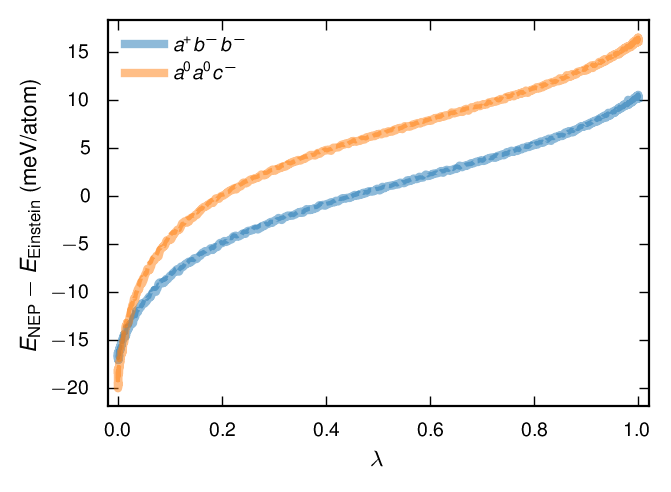

In [19]:
fig, ax = plt.subplots(
    figsize=(3.4, 2.5),
    dpi=200,
)

natoms = 23040
spring = 4
ns, run = 50000, 1
selected_temperature = 50

for glazer, temperature in average_structures:

    if temperature != selected_temperature:
        continue

    dname = f'runs-{xc}/einstein_integration-{glazer}-nat{natoms}-T{temperature}-ns{ns}-spring{spring:.1f}-run{run}'

    # read data
    try:
        df = read_csv(f'{dname}/ti_spring.csv')
    except FileNotFoundError:
        continue
    atoms_ideal = read(f'{dname}/model.xyz')
    n_atoms = len(atoms_ideal)
    
    # free energy from backward and forward switching
    n2 = int(len(df) / 2)
    df_fwd, df_bwd = df[:n2], df[n2:]

    ax.plot(df_fwd['lambda'], 1e3 * (df_fwd.pe - df_fwd.espring - reference_energy),
            '-', lw=3.0, alpha=0.5, label=labels[glazer], color=colors[glazer])
    ax.plot(df_bwd['lambda'], 1e3 * (df_bwd.pe - df_bwd.espring - reference_energy),
            '--', lw=1.5, alpha=0.5, color=colors[glazer])

ax.set_ylabel('$E_\mathrm{NEP} - E_\mathrm{Einstein}$ (meV/atom)')
ax.set_xlabel('$\lambda$')
ax.set_xlim(-0.02, 1.02)
ax.legend(frameon=False)

fig.tight_layout()

In [20]:
data = []
for glazer, temperature in average_structures:
    for fname in glob(f'runs-{xc}/einstein_integration-{glazer}-nat{natoms}-T{temperature}-ns*-spring*/ti_spring.yaml'):
        nsteps = int(fname.split('-ns')[-1].split('-')[0])
        with open(fname) as f:
            row = yaml.load(f, Loader=yaml.FullLoader)
        spring = float(fname.split('/')[1].split('-spring')[-1].split('-')[0])
        row['glazer'] = glazer
        row['temperature'] = temperature
        row['spring'] = spring
        row['nsteps'] = nsteps
        data.append(row)
df_freen = DataFrame(data).sort_values(['glazer', 'temperature', 'spring', 'nsteps'], ignore_index=True)

In [21]:
 dfs_qha = {}
for fname in sorted(glob(f'/Users/prakriti/Downloads/phase-transitions-in-rp-bzs/simulations/free_energy_qha/thermo-{xc}-*-classical.json')):
    sname = fname.split(f'{xc}-')[-1].split('-classical')[0]
    if sname not in invert_glazer:
        continue
    glazer = invert_glazer[sname]
    dfs_qha[glazer] = read_json(fname)

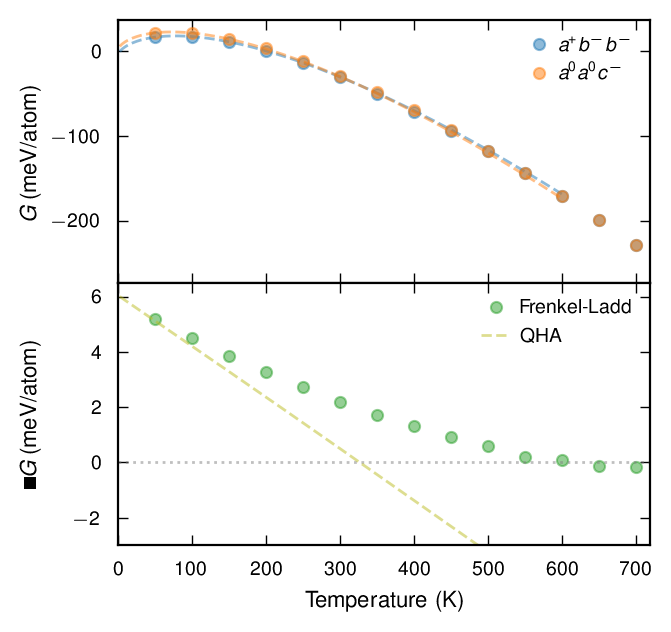

In [22]:
fig, axes = plt.subplots(
    figsize=(3.4, 3.2),
    dpi=200,
    nrows=2,
    sharex=True,
)

df = dfs_qha['a+b-b-']
energy_reference = df[df.temperature < 10].gibbs_free_energy.min()

# absolute free energies
df_sub = df_freen[(df_freen.spring == 4) & (df_freen.nsteps == 50000)]
ax = axes[0]
for (glazer, spring, nsteps), df in df_sub.groupby(['glazer', 'spring', 'nsteps']):
    ax.plot(df.temperature, 1e3 * (df.G - energy_reference),
            'o', ms=4, alpha=0.5, label=labels[glazer], color=colors[glazer])
    df = dfs_qha[glazer]
    ax.plot(df.temperature, 1e3 * (df.gibbs_free_energy - energy_reference),
            '--', alpha=0.5, color=colors[glazer])

# free energy difference from lambda-integration
df_tet = df_sub[df_sub.glazer == 'a0a0c-']
df_ort = df_sub[df_sub.glazer == 'a+b-b-']
df_tet = df_tet[df_tet.temperature.isin(df_ort.temperature)]
df_ort = df_ort[df_ort.temperature.isin(df_tet.temperature)]
df_tet.sort_values('temperature', inplace=True, ignore_index=True)
df_ort.sort_values('temperature', inplace=True, ignore_index=True)
ax = axes[1]
ax.plot(df_tet.temperature, 1e3 * (df_tet.G - df_ort.G),
        'o', ms=4, alpha=0.5, color='C2', label='Frenkel-Ladd')
ax.axhline(0, color='0.5', alpha=0.5, ls=':')

# free energy difference from QHA
df_tet = dfs_qha['a0a0c-']
df_ort = dfs_qha['a+b-b-']
df_tet = df_tet[df_tet.temperature.isin(df_ort.temperature)]
df_tet.sort_values('temperature', inplace=True, ignore_index=True)
df_ort.sort_values('temperature', inplace=True, ignore_index=True)
ax.plot(df_tet.temperature, 1e3 * (df_tet.gibbs_free_energy - df_ort.gibbs_free_energy),
        '--', alpha=0.5, color='C8', label='QHA')

# labels and stuff
axes[0].set_ylabel(r'$G$ (meV/atom)')
axes[1].set_ylabel(r'$\Delta G$ (meV/atom)')
axes[-1].set_xlabel('Temperature (K)')

axes[-1].set_xlim(0, 720)
axes[-1].set_ylim(-3, 6.5)

axes[0].legend(frameon=False, handlelength=1)
axes[1].legend(frameon=False, handlelength=1.5)

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.align_ylabels()

In [23]:
df_tet = df_sub[df_sub.glazer == 'a0a0c-']
df_ort = df_sub[df_sub.glazer == 'a+b-b-']
df_tet = df_tet[df_tet.temperature.isin(df_ort.temperature)]
df_ort = df_ort[df_ort.temperature.isin(df_tet.temperature)]
df_tet.sort_values('temperature', inplace=True, ignore_index=True)
df_ort.sort_values('temperature', inplace=True, ignore_index=True)
ax = axes[1]
ax.plot(df_tet.temperature, 1e3 * (df_tet.G - df_ort.G),
        'o', ms=4, alpha=0.5, color='C2', label='Frenkel-Ladd')
ax.axhline(0, color='0.5', alpha=0.5, ls=':')

In [24]:
df_ort

,E_Einstein,E_diff,F,T,V,P,G,glazer,temperature,spring,nsteps
0,0.018325,-2.046968,-2.028642,50.0,25.149029,0.0,-2.028642,a+b-b-,50,4.0,50000
1,0.018732,-2.046906,-2.028174,100.0,25.192484,0.0,-2.028174,a+b-b-,100,4.0,50000
2,0.012374,-2.046908,-2.034533,150.0,25.236820,0.0,-2.034533,a+b-b-,150,4.0,50000
3,0.001625,-2.046975,-2.045350,200.0,25.279975,0.0,-2.045350,a+b-b-,200,4.0,50000
4,-0.012391,-2.047096,-2.059487,250.0,25.329929,0.0,-2.059487,a+b-b-,250,4.0,50000
5,-0.029009,-2.047338,-2.076347,300.0,25.379309,0.0,-2.076347,a+b-b-,300,4.0,50000
6,-0.047792,-2.047622,-2.095413,350.0,25.429428,0.0,-2.095413,a+b-b-,350,4.0,50000
7,-0.068428,-2.048053,-2.116480,400.0,25.478298,0.0,-2.116480,a+b-b-,400,4.0,50000
8,-0.090683,-2.048560,-2.139243,450.0,25.528269,0.0,-2.139243,a+b-b-,450,4.0,50000
9,-0.114378,-2.049168,-2.163546,500.0,25.583990,0.0,-2.163546,a+b-b-,500,4.0,50000


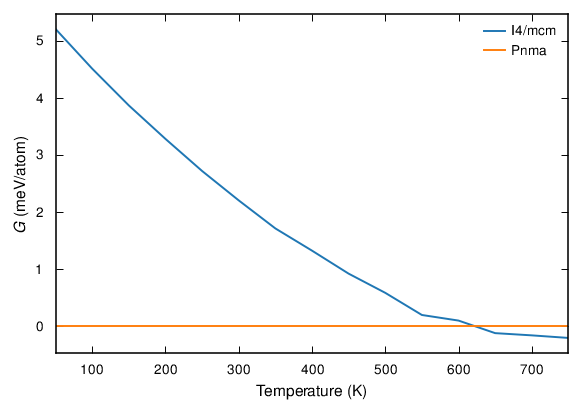

In [25]:

fig, ax = plt.subplots(figsize=(4.2, 3), dpi=140)
ax.plot(df_ort.temperature, 1000 * (df_tet.G-df_ort.G), label = 'I4/mcm')
ax.plot(df_ort.temperature, 1000 * (df_ort.G-df_ort.G), label = 'Pnma')
ax.set_xlim(50,750)
ax.set_ylabel(r'$G$ (meV/atom)')
ax.set_xlabel('Temperature (K)')
ax.legend(frameon=False, handlelength=1.5)
fig.tight_layout()
fig.align_ylabels()
fig.savefig('TI.png')